In [1]:
import os

from transformers import AutoTokenizer, AutoModel
import sqlite3
import pandas as pd
import numpy as np
import torch
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, adjusted_mutual_info_score

import matplotlib.pyplot as plt
import pickle

from data import fetch_reports_as_df, clean_text
from plot_util import plot_2d_chart_with_different_fz, plot_2d_charts_with_mixed, plot_2d_charts, plot_2d_with_different_models

In [2]:
REPORT_DB_PATH = "/pub4/data/czhao/reports.db"

model_name = 'medicalai/ClinicalBERT'

result_dir = "/pub4/data/czhao/eeg_results/clustering/"
os.makedirs(result_dir, exist_ok=True)

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

df = fetch_reports_as_df(REPORT_DB_PATH)

/home/czhao/anaconda3/envs/aloha/lib/python3.8/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [3]:
def llm_embedding(model, tokenizer, df, save_path):
    for i, row in df.iterrows():
        text = row["Text"]
        text = clean_text(text)
        inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
        outputs = model(**inputs)
        embeddings = outputs.last_hidden_state
        embeddings = torch.mean(embeddings, dim=1).squeeze()
        if i == 0:
            all_embeddings = embeddings
        else:
            # Stack all embeddings
            all_embeddings = torch.vstack((all_embeddings, embeddings))
    
    all_embeddings = all_embeddings.detach().numpy()

    # Fit StandardScaler
    scaler = StandardScaler()
    all_embeddings = scaler.fit_transform(all_embeddings)

    np.savetxt(save_path, all_embeddings, delimiter=",")

    return all_embeddings, scaler

In [4]:
llm_embedding(model, tokenizer, df, os.path.join(result_dir, "llm_embeddings.csv"))

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


KeyboardInterrupt: 

In [3]:
# read embeddings
embeddings = pd.read_csv(os.path.join(result_dir, "llm_embeddings.csv"), header=None)

In [1]:
os.chdir("./FuzzyJMeansVNS")
from FuzzyJMeansVNS.fvjm import fit

os.chdir("..")

def fz_jm(embeddings_df, save_dir, n_clusters=2, fuzzy_factors=[1.25, 1.5, 1.75, 2.0, 2.25]):
    # Fuzzy J-Means
    result_dict = {}
    for ff in fuzzy_factors:
        result_dict[ff] = fit(embeddings_df, n_clusters, ff)
        save_path = os.path.join(save_dir, f"fz_jm_results_{ff}.csv")
        result_dict[ff][0][0].to_csv(save_path.format(ff), index=False)

    return result_dict

def run_fz_experiment(embeddings, df, result_dir, n_experiments=10, fuzzy_factors=[1.25, 1.5, 1.75, 2.0, 2.25]):
    result = {}
    for i in range(n_experiments):
        print(f"Experiment {i}")
        result_dict = fz_jm(embeddings, result_dir, n_clusters=2, fuzzy_factors=fuzzy_factors)
        for ff, fjm_result in result_dict.items():
            if ff not in result:
                result[ff] = {
                    "Silhouette Score": 0,
                    "Adjusted Mutual Info Score": 0,
                    "Time": 0,
                    "Previous Best Silhouette Score": -1,
                    "Previous Best Membership": None,
                    "FCM Objective": 0,
                    "FJM Objective": 0
                }
            # Calculate the metric scores
            labels = fjm_result[0][1]["Label"]
            s_score = silhouette_score(embeddings, labels)
            a_score = adjusted_mutual_info_score(df["Label"], labels)
            print(f"Fuzzy Factor: {ff}, Silhouette Score: {s_score}, Adjusted Mutual Info Score: {a_score}")
            # Update the result
            result[ff]["Silhouette Score"] += s_score
            result[ff]["Adjusted Mutual Info Score"] += a_score
            result[ff]["Time"] += fjm_result[2][1]
            result[ff]["FCM Objective"] += fjm_result[1][0]
            result[ff]["FJM Objective"] += fjm_result[1][1]
            if s_score > result[ff]["Previous Best Silhouette Score"]:
                result[ff]["Previous Best Silhouette Score"] = s_score
                result[ff]["Previous Best Membership"] = fjm_result[0][1]
    # Average the results
    for ff in result:
        result[ff]["Silhouette Score"] /= n_experiments
        result[ff]["Adjusted Mutual Info Score"] /= n_experiments
        result[ff]["Time"] /= n_experiments
    return result
    
    

def load_fz_results(result_dir, fuzzy_factors=[1.25, 1.5, 1.75, 2.0]):
    result_dict = {}
    for ff in fuzzy_factors:
        result_dict[ff] = pd.read_csv(os.path.join(result_dir, f"fz_jm_results_{ff}.csv"))
    return result_dict

NameError: name 'os' is not defined

In [5]:
def run_dimension_reduction_experiments(embeddings, df, result_dir, n_experiments=10, fuzzy_factor=1.5, n_components=[64, 100]):
    result_dict = {}
    # Add original embeddings
    n_components.append(embeddings.shape[1])
    for n_component in n_components:
        if n_component not in result_dict:
            result_dict[n_component] = {}
            for method in ["FCM", "FJM"]:
                result_dict[n_component][method] = {
                    "Silhouette Score": 0,
                    "Adjusted Mutual Info Score": 0,
                    "Objective": 0,
                    "Time": 0,
                    "preivous Best Silhouette Score": -1,
                    "Previous Best Membership": None
                }
        if n_component == embeddings.shape[1]:
            reduced_embeddings = embeddings
        else:
            pca = PCA(n_components=n_component)
            reduced_embeddings = pca.fit_transform(embeddings)
            # To df
            reduced_embeddings = pd.DataFrame(reduced_embeddings)
        print(f"Reduced Embeddings Shape: {reduced_embeddings.shape}")
        for i in range(n_experiments):
            print(f"Experiment {i}")
            result_dfs, result_objs, result_times = fit(reduced_embeddings, 2, fuzzy_factor)

            for i, method in enumerate(["FCM", "FJM"]):
                labels = result_dfs[i]["Label"]
                s_score = silhouette_score(reduced_embeddings, labels)
                a_score = adjusted_mutual_info_score(df["Label"], labels)

                result_dict[n_component][method]["Silhouette Score"] += s_score
                result_dict[n_component][method]["Adjusted Mutual Info Score"] += a_score
                result_dict[n_component][method]["Objective"] += result_objs[i]
                result_dict[n_component][method]["Time"] += result_times[i]
                if s_score > result_dict[n_component][method]["preivous Best Silhouette Score"]:
                    result_dict[n_component][method]["preivous Best Silhouette Score"] = s_score
                    result_dict[n_component][method]["Previous Best Membership"] = labels
        for method in ["FCM", "FJM"]:
            result_dict[n_component][method]["Silhouette Score"] /= n_experiments
            result_dict[n_component][method]["Adjusted Mutual Info Score"] /= n_experiments
            result_dict[n_component][method]["Objective"] /= n_experiments
            result_dict[n_component][method]["Time"] /= n_experiments
    return result_dict


In [7]:
fz_results = run_fz_experiment(embeddings, df, result_dir, n_experiments=10, fuzzy_factors=[2.25, 2.5])
# Save the results
with open(os.path.join(result_dir, "fz_results_more.pkl"), "wb") as f:
    pickle.dump(fz_results, f)

NameError: name 'run_fz_experiment' is not defined

In [4]:
pca_results = run_dimension_reduction_experiments(embeddings, df, result_dir, n_experiments=10, fuzzy_factor=1.5, n_components=[64, 100])
# Save the results
with open(os.path.join(result_dir, "pca_results.pkl"), "wb") as f:
    pickle.dump(pca_results, f)

NameError: name 'run_dimension_reduction_experiments' is not defined

In [8]:
# Load the results
with open(os.path.join(result_dir, "fz_results.pkl"), "rb") as f:
    fz_results = pickle.load(f)
fz_results
with open(os.path.join(result_dir, "fz_results_more.pkl"), "rb") as f:
    fz_results_more = pickle.load(f)
# Concatenate the results
for ff in fz_results_more:
    fz_results[ff] = fz_results_more[ff]
fz_results

{1.25: {'Silhouette Score': 0.09714344257206378,
  'Adjusted Mutual Info Score': 0.3130969648485797,
  'Time': 3.7346638679504394,
  'Previous Best Silhouette Score': 0.11405245542071515,
  'Previous Best Membership':            1         2  Label
  0   0.048124  0.951876      2
  1   0.486223  0.513777      2
  2   0.092707  0.907293      2
  3   0.168301  0.831699      2
  4   0.063015  0.936985      2
  ..       ...       ...    ...
  95  0.344140  0.655860      2
  96  0.243604  0.756396      2
  97  0.174769  0.825231      2
  98  0.204329  0.795671      2
  99  0.199032  0.800968      2
  
  [100 rows x 3 columns],
  'FCM Objective': 635030.2376212557,
  'FJM Objective': 635030.2376212557},
 1.5: {'Silhouette Score': 0.09635172443634817,
  'Adjusted Mutual Info Score': 0.28771677470657925,
  'Time': 3.747113060951233,
  'Previous Best Silhouette Score': 0.1035441450661408,
  'Previous Best Membership':            1         2  Label
  0   0.262806  0.737194      2
  1   0.686577  

In [9]:
# Create a latex table
# Columns = Fuzzy Factor, Silhouette Score, Adjusted Mutual Info Score, Time
# Rows = Fuzzy Factor
# Values = Average of the metrics
# print the latex table
print("\\begin{table}[H]")
print("\\centering")
print("\\begin{tabular}{|c|c|c|c|c|}")
print("\\hline")
print("Fuzzy Factor & Silhouette Score & Adjusted Mutual Info Score & Time (s) \\\\")
print("\\hline")
for ff, result in fz_results.items():
    # Round the values
    result["Silhouette Score"] = round(result["Silhouette Score"], 2)
    result["Adjusted Mutual Info Score"] = round(result["Adjusted Mutual Info Score"], 2)
    result["Time"] = round(result["Time"], 2)
    print(f"{ff} & {result['Silhouette Score']} & {result['Adjusted Mutual Info Score']} & {result['Time']} \\\\")
print("\\hline")
print("\\end{tabular}")
print("\\caption{Fuzzy J-Means Results}")
print("\\end{table}")

\begin{table}[H]
\centering
\begin{tabular}{|c|c|c|c|c|}
\hline
Fuzzy Factor & Silhouette Score & Adjusted Mutual Info Score & Time (s) \\
\hline
1.25 & 0.1 & 0.31 & 3.73 \\
1.5 & 0.1 & 0.29 & 3.75 \\
1.75 & 0.09 & 0.34 & 3.75 \\
2.0 & 0.09 & 0.38 & 3.71 \\
2.25 & 0.09 & 0.41 & 3.7 \\
2.5 & 0.09 & 0.35 & 3.71 \\
\hline
\end{tabular}
\caption{Fuzzy J-Means Results}
\end{table}


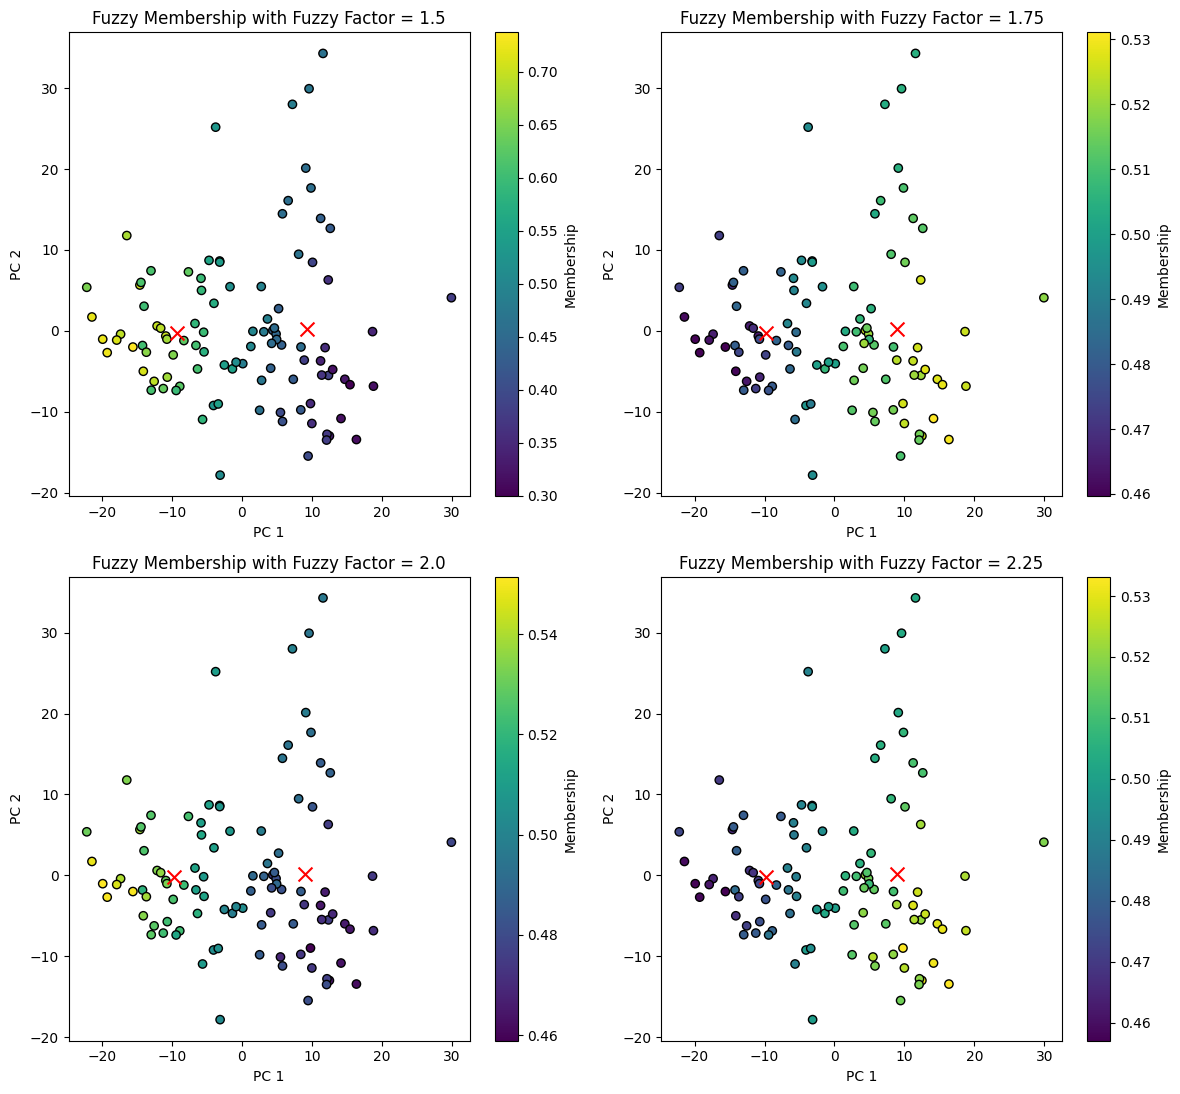

In [5]:
# Plot the result with ff = 1.5 1.75 2.0 2.25
# Create a new dict
fz_results_plot = {}
for ff in [1.5, 1.75, 2.0, 2.25]:
    fz_results_plot[ff] = fz_results[ff]['Previous Best Membership']

plot_2d_chart_with_different_fz(
    embeddings,
    fz_results_plot,
    os.path.join(result_dir, "fz_results_plot.png")
)

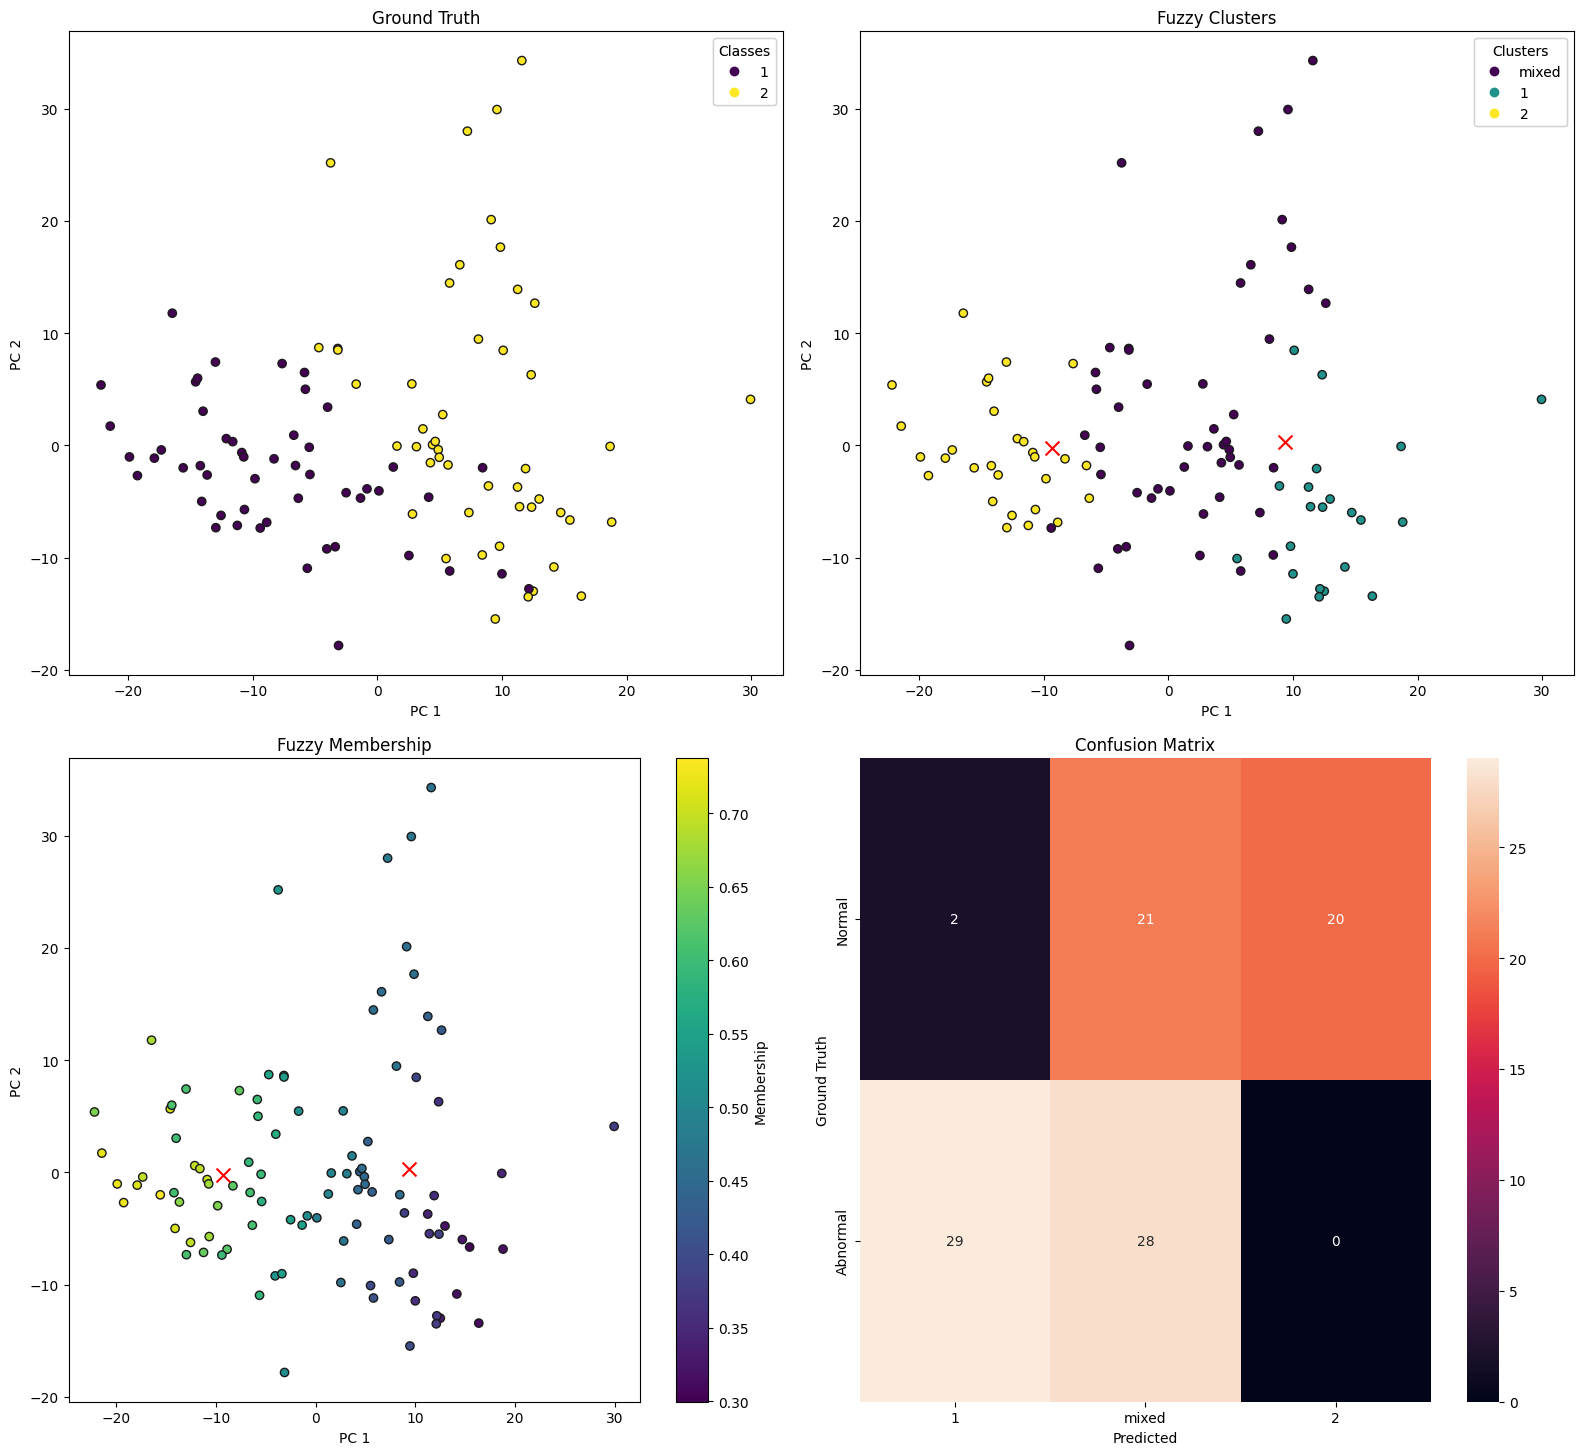

In [5]:
plot_df = fz_results[1.5]['Previous Best Membership'].copy()
plot_2d_charts_with_mixed(
    embeddings,
    plot_df,
    df["Label"],
    os.path.join(result_dir, "fz_results_plot_mixed.png")
)

In [5]:
# load pca results
with open(os.path.join(result_dir, "pca_results.pkl"), "rb") as f:
    pca_results = pickle.load(f)
pca_results

{64: {'FCM': {'Silhouette Score': 0.10748654071797278,
   'Adjusted Mutual Info Score': 0.4499433639723064,
   'Objective': 52575.861504149725,
   'Time': 12.315810513496398,
   'preivous Best Silhouette Score': 0.10748654071797276,
   'Previous Best Membership': 0     2
   1     1
   2     2
   3     2
   4     2
        ..
   95    1
   96    1
   97    2
   98    2
   99    2
   Name: Label, Length: 100, dtype: int64},
  'FJM': {'Silhouette Score': 0.09800321925103382,
   'Adjusted Mutual Info Score': 0.38942874616490425,
   'Objective': 52575.861504149725,
   'Time': 0.3253554582595825,
   'preivous Best Silhouette Score': 0.10831421751534119,
   'Previous Best Membership': 0     2
   1     1
   2     2
   3     2
   4     2
        ..
   95    1
   96    1
   97    2
   98    2
   99    2
   Name: Label, Length: 100, dtype: int64}},
 100: {'FCM': {'Silhouette Score': 0.1030984674740151,
   'Adjusted Mutual Info Score': 0.4499433639723064,
   'Objective': 54305.80085782592,
   'Tim

In [8]:
# Create a latex table for the results
# columns = Method, # of components, Silhouette Score, AMI Score, Objective, Time
# Print in latex format
print("\\begin{table}[H]")
print("\\centering")
print("\\begin{tabular}{|c|c|c|c|c|c|}")
print("\\hline")
print("Method & Number of Components & Silhouette Score & AMI Score & Objective & Time \\\\")
print("\\hline")
for n_component, result_dict in pca_results.items():
    for method, result in result_dict.items():
        print(f"{method} & {n_component} & {result['Silhouette Score']:.2f} & {result['Adjusted Mutual Info Score']:.2f} & {result['Objective']:.2f} & {result['Time']:.2f} \\\\")

print("\\hline")
print("\\end{tabular}")
print("\\caption{PCA Results}")
print("\\end{table}")

\begin{table}[H]
\centering
\begin{tabular}{|c|c|c|c|c|c|}
\hline
Method & Number of Components & Silhouette Score & AMI Score & Objective & Time \\
\hline
FCM & 64 & 0.11 & 0.45 & 52575.86 & 12.32 \\
FJM & 64 & 0.10 & 0.39 & 52575.86 & 0.33 \\
FCM & 100 & 0.10 & 0.45 & 54305.80 & 1.75 \\
FJM & 100 & 0.09 & 0.35 & 54305.80 & 0.49 \\
FCM & 768 & 0.10 & 0.45 & 54305.80 & 8.78 \\
FJM & 768 & 0.09 & 0.31 & 54305.80 & 3.69 \\
\hline
\end{tabular}
\caption{PCA Results}
\end{table}


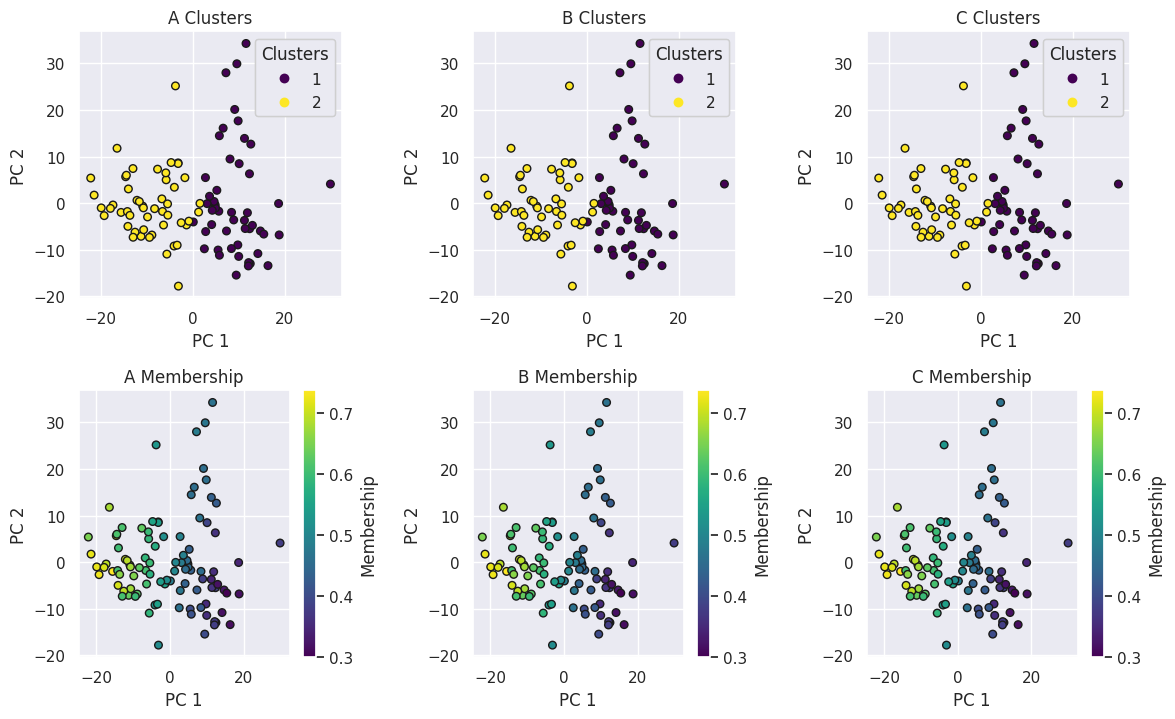

In [9]:
plot_df = fz_results[1.5]['Previous Best Membership']
model_dict = {
    "A": (embeddings, plot_df),
    "B": (embeddings, plot_df), # Replace with other models' embeddings
    "C": (embeddings, plot_df)
}
plot_2d_with_different_models(model_dict, os.path.join(result_dir, "different_models.png"))